# PROXIMITY PLOTS FOR RANDOM FOREST

The main code skeleton is taken from the following TensorFlow tutorial: https://www.tensorflow.org/decision_forests/tutorials/proximities_colab

In [44]:
# Install TensorFlow Dececision Forests an£d the dependencies used in this colab.
!pip install tensorflow_decision_forests plotly scikit-learn wurlitzer -U -qq

In [45]:
# import packages
import tensorflow_decision_forests as tfdf
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.colors as mcolors
import math
import os
import random
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objs as go

In [50]:
# load MNIST data set of hand-written digits
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

The true label is: 0


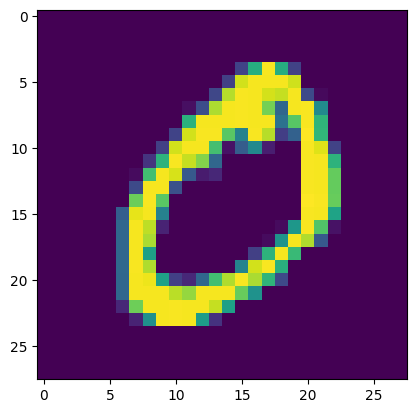

In [51]:
# visualize an image
plt.imshow(x_train[1])
print("The true label is: " + str(y_train[1]))

In [52]:
# keep fraction of images (e.g. 1000 train and 100 test)
n_train = 5000
n_test = 100

x_train = x_train[:n_train]
y_train = y_train[:n_train]
x_test = x_test[:n_test]
y_test = y_test[:n_test]

In [53]:
# transform each image (from matrix) to long vector of dim 28*28
x_train = x_train.reshape(n_train , 28*28)
x_test = x_test.reshape(n_test, 28*28)
# and fro unit-8 to float32
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

In [54]:
# make into a df
data_train = pd.concat( (pd.DataFrame(x_train), pd.DataFrame(y_train).rename(columns = {0:"label"})),axis = 1)
data_test = pd.concat( (pd.DataFrame(x_test), pd.DataFrame(y_test).rename(columns = {0:"label"})),axis = 1)

In [55]:
# change col names
for i in range(data_train.shape[1]-1):
  data_train.rename(columns = {i:str(i)}, inplace = True)
for i in range(data_test.shape[1]-1):
  data_test.rename(columns = {i:str(i)}, inplace = True)

In [56]:
# , and convert it into a TensorFlow dataset.
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(data_train, label="label")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(data_test, label="label")

In [57]:
# Train a Random Forest
model = tfdf.keras.RandomForestModel(num_trees=1000, random_seed = 99)
model.fit(train_ds)

Use /tmp/tmpveclzv3h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:23.051930. Found 5000 examples.
Training model...
Model trained in 0:03:15.954658
Compiling model...


Model compiled.


In [58]:
model_inspector = model.make_inspector()
out_of_bag_accuracy = model_inspector.evaluation().accuracy
print(f"Out-of-bag accuracy: {out_of_bag_accuracy:.4f}")

Out-of-bag accuracy: 0.9396


In [59]:
# The test accuracy is measured on the test datasets.
model.compile(["accuracy"])
test_accuracy = model.evaluate(test_ds, return_dict=True, verbose=0)["accuracy"]
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.9600


In [60]:
print("The model contains", model_inspector.num_trees(), "trees.")
print("The test dataset contains", data_test.shape[0], "examples.")

The model contains 1000 trees.
The test dataset contains 100 examples.


In [61]:
leaves = model.predict_get_leaves(test_ds)
print("The leaf indices:\n", leaves)

The leaf indices:
 [[101   7 105 ...  16   9  95]
 [ 74 175 207 ...  92 222 266]
 [ 53  41  29 ... 134 201  20]
 ...
 [200 275 191 ... 215 280 154]
 [ 22 233  87 ...  35  71 209]
 [172 263 183 ...  87 299 169]]


In [62]:
print("The predicted leaves have shape", leaves.shape,
      "(we expect [num_examples, num_trees]")

The predicted leaves have shape (100, 1000) (we expect [num_examples, num_trees]


In [63]:
def compute_proximity(leaves, step_size=100):
  """Computes the proximity between each pair of examples.

  Args:
    leaves: A matrix of shape [num_example, num_tree] where the value [i,j] is
      the index of the leaf reached by example "i" in the tree "j".
    step_size: Size of the block of examples for the computation of the
      proximity. Does not impact the results.

  Returns:
    The example pair-wise proximity matrix of shape [n,n] with "n" the number of
    examples.
  """

  example_idx = 0
  num_examples = leaves.shape[0]
  t_leaves = np.transpose(leaves)
  proximities = []

  # Instead of computing the proximity in between all the examples at the same
  # time, we compute the similarity in blocks of "step_size" examples. This
  # makes the code more efficient with the the numpy broadcast.
  while example_idx < num_examples:
    end_idx = min(example_idx + step_size, num_examples)
    proximities.append(
        np.mean(
            leaves[..., np.newaxis] == t_leaves[:,
                                                example_idx:end_idx][np.newaxis,
                                                                     ...],
            axis=1))
    example_idx = end_idx
  return np.concatenate(proximities, axis=1)


proximity = compute_proximity(leaves)
print("The shape of proximity is", proximity.shape)

The shape of proximity is (100, 100)


In [64]:
# compute distance matrix
distance = 1 - proximity

# use t-stochastic nearest embedding to visualize the distance matrix
t_sne = TSNE(
    # Number of dimensions to display. 3d is also possible.
    n_components=2,
    # Control the shape of the projection. Higher values create more
    # distinct but also more collapsed clusters. Can be in 5-50.
    perplexity=20,
    metric="precomputed",
    init="random",
    verbose=1,
    random_state = 99,
    learning_rate="auto").fit_transform(distance)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.244325
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.114334
[t-SNE] KL divergence after 950 iterations: 0.279888


In [65]:
y_pred = model.predict(test_ds)
y_pred = np.matrix(y_pred).argmax(axis = 1)

1/1 [==============================] - 1s 966ms/step


Text(0.5, 1.0, 'Proximity Plot for hand-written digits classification')

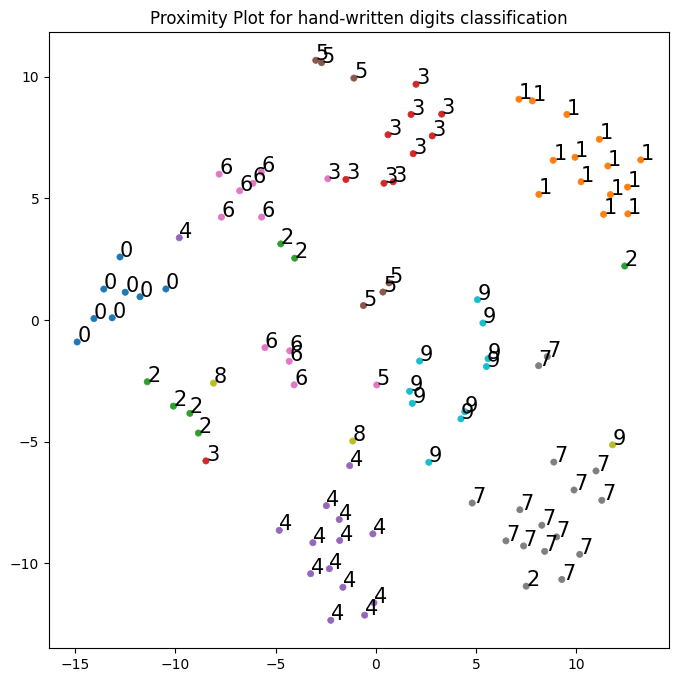

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.grid(False)

categories = [str(i) for i in range(10)]  # Digit labels

# color according to prediction of RF
ax.scatter(
      t_sne[:, 0], t_sne[:, 1], c = np.array(y_pred), cmap = "tab10", linewidths=0.5, marker = "o", s=20)

# Add a legend with unique labels

#plt.legend()


for idx, (x, y) in enumerate(zip(t_sne[:, 0], t_sne[:, 1])):
    plt.text(x, y, data_test["label"][idx], c = "black", fontsize=15)
# legend
plt.title("Proximity Plot for hand-written digits classification")
# ....

# Code for visualization in 3 dimensions

In [35]:
# compute distance matrix
distance = 1 - proximity

# use t-stochastic nearest embedding to visualize the distance matrix
t_sne = TSNE(
    # Number of dimensions to display. 3d is also possible.
    n_components=3,
    # Control the shape of the projection. Higher values create more
    # distinct but also more collapsed clusters. Can be in 5-50.
    perplexity=20,
    metric="precomputed",
    init="random",
    verbose=1,
    random_state = 99,
    learning_rate="auto").fit_transform(distance)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.004s...
[t-SNE] Computed neighbors for 100 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.285117
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.573120
[t-SNE] KL divergence after 1000 iterations: 1.367602


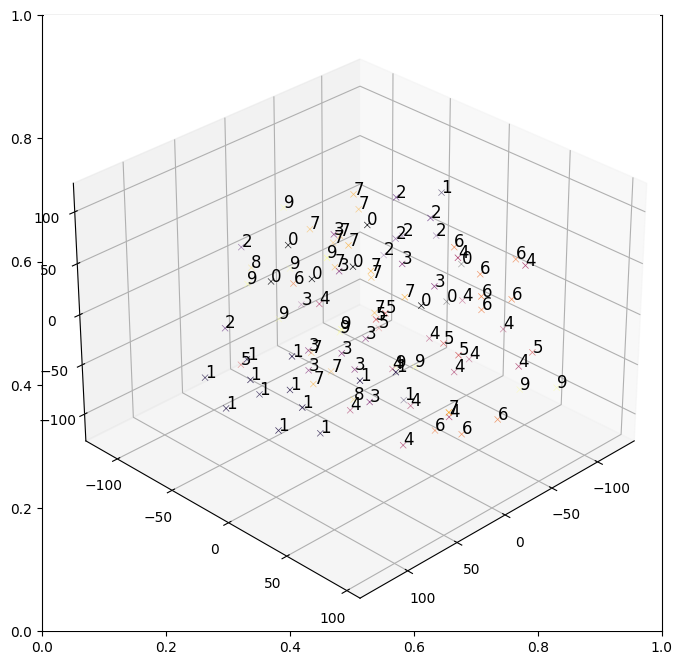

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.grid(False)
ax = fig.add_subplot(projection='3d')

# Color the points according to the label value.
#colors = (data_test["label"]).map(lambda x: ["orange", "green"][x])
ax.scatter(t_sne[:, 0], t_sne[:, 1], t_sne[:, 2], c = data_test["label"], cmap = "inferno", linewidths=0.5, marker = "x", s=20)
for idx, (x, y, z) in enumerate(zip(t_sne[:, 0], t_sne[:, 1], t_sne[:, 2])):
    ax.text(x, y, z, data_test["label"][idx], c = "black", fontsize=12)

# adjust perpective here
ax.view_init(elev=30., azim=45, roll=0) # adjust perpective here